# KD Seminar
## Analyse der Modelle RNN/CNN

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [108]:
finance_data = pd.read_csv("finance_data/data/aggregated_returns.csv",index_col=0)

# Load portfolio data
#
#portfolio_data = pd.read_csv("mlp/predictions/predictions_rnn.csv",sep='\t')
portfolio_data = pd.read_csv("mlp/predictions/predictions_frst_model.csv")



# Both Ascending by Time
finance_data = finance_data.sort_values('Timestamp')
portfolio_data = portfolio_data.sort_values('Timestamp')

# Set Index
finance_data = finance_data.set_index('Timestamp')
portfolio_data = portfolio_data.set_index('Timestamp')

stocks = finance_data.columns

In [109]:
# Set Both Datasets on same time range
start = max(portfolio_data.index.min(),finance_data.index.min())
end =  min(portfolio_data.index.max(),finance_data.index.max())
finance_data = finance_data.loc[start:end]
portfolio_data = portfolio_data.loc[start:end]


# Check has to be 0
portfolio_data.shape[0] - finance_data.shape[0]

0

---

In [116]:
finance_data.iloc[0] = 0
finance_data['Hallo'] = finance_data['Samsung'].shift(1)
finance_data

,Samsung,Telefonica,Allianz,Total,Bayer,Tesla,Airbus,Apple,BASF,BMW,Google,Hallo
Timestamp,,,,,,,,,,,,
2016-05-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2016-05-10,0.003091,-0.006478,0.020318,-0.000563,0.001499,-0.001293,0.001080,0.009789,0.008587,0.014331,0.000554,0.000000
2016-05-11,0.008550,0.007290,0.015240,-0.000375,0.049716,0.008072,0.004692,0.023736,0.021274,0.015464,0.006860,0.003091
2016-05-12,0.022100,0.026361,-0.008374,0.008482,-0.010351,-0.001591,0.002536,-0.001990,-0.011284,0.026090,0.006236,0.008550
2016-05-13,0.003998,-0.012443,0.006183,-0.006039,0.004065,-0.003270,0.018487,-0.036447,0.000591,0.030416,-0.006856,0.022100
2016-05-17,-0.003160,0.035567,-0.004368,-0.001122,-0.006974,-0.031313,0.017142,-0.011380,0.000591,0.007997,0.010435,0.003998
2016-05-18,-0.001576,0.015639,0.010223,0.003183,0.085599,-0.018951,-0.001690,0.003814,0.016394,0.004659,-0.009784,-0.003160
2016-05-19,0.000788,-0.019940,-0.010949,-0.014150,-0.011571,-0.023285,-0.020244,-0.010770,-0.011058,-0.014611,0.003230,-0.001576
2016-05-20,-0.013307,0.007755,0.000363,0.002777,0.058881,0.018603,-0.002387,-0.012627,0.000892,0.012349,-0.005352,0.000788


In [98]:
# Shift portfolio binary variable to day where investment get paid out
# Set 1 to day when return is realized or 0 when return is not realized
# shift > 0 --> Shift nach unten
# shift < 0 --> shift nach oben
for stock in stocks:
    portfolio_data[stock] = portfolio_data[stock].shift(1)

# Cant invest before the first day 
portfolio_data=portfolio_data.fillna(0)

---

In [99]:
# Calculate Mean return for equal weighted strategy
equal_weighted_mean = finance_data.mean(1,True)

# Shorting?
#finance_data = finance_data.apply(lambda row: row*-1)
#finance_data['Equal_Weighted_Mean'] = finance_data['Equal_Weighted_Mean']*-1

In [100]:
# Reset Index
# Damit .loc[] funktioniert
finance_data = finance_data.reset_index()
portfolio_data = portfolio_data.reset_index()

In [101]:
# Clear all return entries, where we do not want to invest
for stock in stocks:
    finance_data.loc[np.where(portfolio_data[stock]==0)[0],[stock]] = np.nan

In [102]:
# Calculate mean returns for model
finance_data['Model_Mean'] = finance_data.mean(1,True)
finance_data['Equal_Weighted_Mean'] = equal_weighted_mean.values



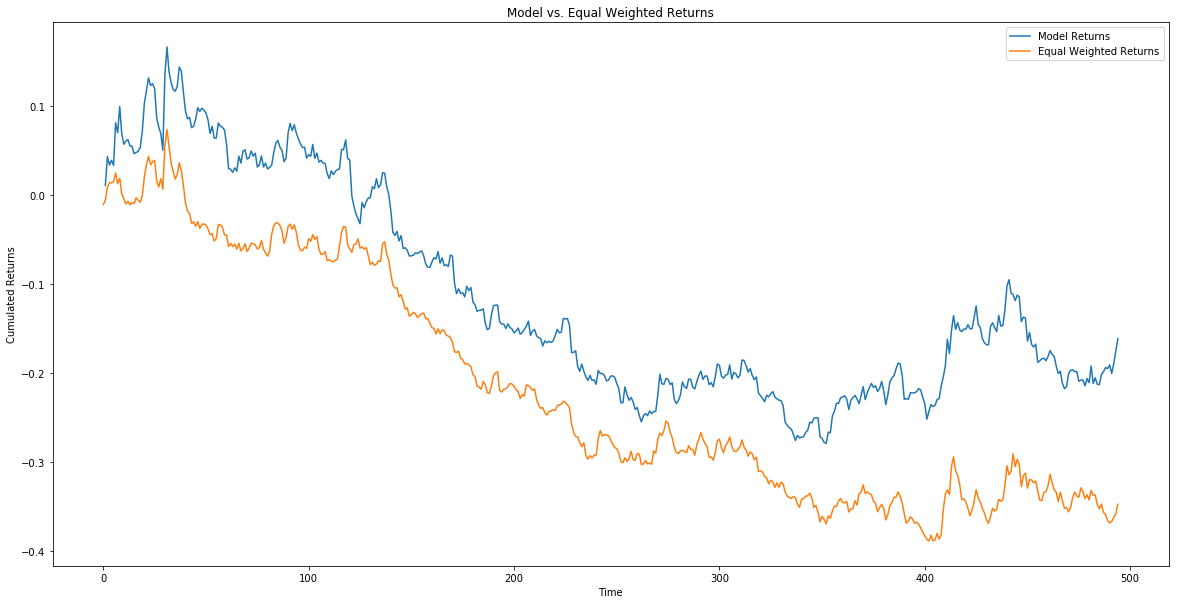

In [104]:
# Plot Model vs Equal Weight Strategy

plt.figure(0,figsize=[20,10])
plt.plot(finance_data['Model_Mean'].cumsum(),label="Model Returns")
plt.plot(finance_data['Equal_Weighted_Mean'].cumsum(),label="Equal Weighted Returns")

plt.title("Model vs. Equal Weighted Returns")
plt.xlabel("Time")
plt.ylabel("Cumulated Returns")
plt.legend()
plt.show()


---

---

In [68]:
portfolio_data[0:10]

,Timestamp,Samsung,Telefonica,Allianz,Total,Bayer,Tesla,Airbus,Apple,BASF,BMW,Google
0,2016-05-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-05-10,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-05-11,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-05-12,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-05-13,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-05-17,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-05-18,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2016-05-19,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2016-05-20,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2016-05-23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
finance_data[0:10]

,Timestamp,Samsung,Telefonica,Allianz,Total,Bayer,Tesla,Airbus,Apple,BASF,BMW,Google,Model_Mean,Equal_Weighted_Mean
0,2016-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-05-10,NaN,NaN,0.020318,NaN,0.001499,NaN,NaN,NaN,NaN,NaN,NaN,0.010908,NaN
2,2016-05-11,NaN,NaN,0.015240,NaN,0.049716,NaN,NaN,NaN,NaN,NaN,NaN,0.032478,NaN
3,2016-05-12,NaN,NaN,-0.008374,NaN,-0.010351,NaN,NaN,NaN,NaN,NaN,NaN,-0.009363,NaN
4,2016-05-13,NaN,NaN,0.006183,NaN,0.004065,NaN,NaN,NaN,NaN,NaN,NaN,0.005124,NaN
5,2016-05-17,NaN,NaN,-0.004368,NaN,-0.006974,NaN,NaN,NaN,NaN,NaN,NaN,-0.005671,NaN
6,2016-05-18,NaN,NaN,0.010223,NaN,0.085599,NaN,NaN,NaN,NaN,NaN,NaN,0.047911,NaN
7,2016-05-19,NaN,NaN,-0.010949,NaN,-0.011571,NaN,NaN,NaN,NaN,NaN,NaN,-0.011260,NaN
8,2016-05-20,NaN,NaN,0.000363,NaN,0.058881,NaN,NaN,NaN,NaN,NaN,NaN,0.029622,NaN
9,2016-05-23,NaN,NaN,-0.030045,NaN,-0.031827,NaN,NaN,NaN,NaN,NaN,NaN,-0.030936,NaN


In [25]:
finance_data[0:10].apply(lambda row: row*-1)

,Timestamp,Samsung,Telefonica,Allianz,Total,Bayer,Tesla,Airbus,Apple,BASF,BMW,Google,Equal_Weighted_Mean,Model_Mean
0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010444,0.010444
1,,NaN,NaN,-0.020318,NaN,-0.001499,NaN,NaN,NaN,NaN,NaN,NaN,-0.004629,-0.008815
2,,NaN,NaN,-0.015240,NaN,-0.049716,NaN,NaN,NaN,NaN,NaN,NaN,-0.014593,-0.026516
3,,NaN,NaN,0.008374,NaN,0.010351,NaN,NaN,NaN,NaN,NaN,NaN,-0.005292,0.004478
4,,NaN,NaN,-0.006183,NaN,-0.004065,NaN,NaN,NaN,NaN,NaN,NaN,0.000120,-0.003376
5,,NaN,NaN,0.004368,NaN,0.006974,NaN,NaN,NaN,NaN,NaN,NaN,-0.001220,0.003374
6,,NaN,NaN,-0.010223,NaN,-0.085599,NaN,NaN,NaN,NaN,NaN,NaN,-0.009774,-0.035199
7,,NaN,NaN,0.010949,NaN,0.011571,NaN,NaN,NaN,NaN,NaN,NaN,0.012051,0.011524
8,,NaN,NaN,-0.000363,NaN,-0.058881,NaN,NaN,NaN,NaN,NaN,NaN,-0.006177,-0.021807
9,,NaN,NaN,0.030045,NaN,0.031827,NaN,NaN,NaN,NaN,NaN,NaN,0.017764,0.026545
